# MobileNetV2 with Synthetic Face Data

Dataset from [Kaggle](https://www.kaggle.com/datasets/allexmendes/synthetic-gaze-and-face-segmentation/data)

This notebook trains a gaze prediction model using a dual-input CNN:
- **Input 1**: 224×224 face image (see the other notebook for preprocessing)
- **Input 2**: 4D pupil coordinate vector (`L_Pupil` and `R_Pupil`)
- **Output**: 2D normalized gaze direction vector (from `ImageEyesGazeDirection` annotation)

We use MobileNetV2 as the backbone for the visual stream and concatenate it with pupil coordinates before regression.

In [2]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [3]:
!pip install albumentations

  Using cached albumentations-2.0.7-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached stringzilla-3.12.5-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl.metadata (80 kB)
  Using cached simsimd-6.2.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (66 kB)
Using cached albumentations-2.0.7-py3-none-any.whl (367 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
Using cached simsimd-6.2.1-cp312-cp312-manylinux_2_28_x86_64.whl (633 kB)
Using cached stringzilla-3.12.5-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl (308 kB)


In [ ]:
!pip install tensorflowjs

In [5]:
!pip install optree==0.14.0

  Using cached optree-0.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (47 kB)
Using cached optree-0.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (400 kB)
  Attempting uninstall: optree
    Found existing installation: optree 0.15.0
    Uninstalling optree-0.15.0:
      Successfully uninstalled optree-0.15.0


In [4]:
!whereis cuda

cuda: /usr/local/cuda


In [5]:
!sudo apt-get install -y cuda-compiler-12-2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cuda-cccl-12-2 cuda-crt-12-2 cuda-cudart-12-2 cuda-cudart-dev-12-2
  cuda-cuobjdump-12-2 cuda-cuxxfilt-12-2 cuda-driver-dev-12-2 cuda-nvcc-12-2
  cuda-nvprune-12-2 cuda-nvvm-12-2 cuda-toolkit-12-2-config-common
The following NEW packages will be installed:
  cuda-cccl-12-2 cuda-compiler-12-2 cuda-crt-12-2 cuda-cudart-12-2
  cuda-cudart-dev-12-2 cuda-cuobjdump-12-2 cuda-cuxxfilt-12-2
  cuda-driver-dev-12-2 cuda-nvcc-12-2 cuda-nvprune-12-2 cuda-nvvm-12-2
  cuda-toolkit-12-2-config-common
0 upgraded, 12 newly installed, 0 to remove and 0 not upgraded.
Need to get 49.8 MB of archives.
After this operation, 216 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  cuda-cccl-12-2 12.2.140-1 [1187 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/

In [2]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/conda'

import tensorflow as tf

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

2025-05-26 12:26:28.868791: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 12:26:28.888572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748262388.908045    8847 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748262388.914028    8847 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748262388.929338    8847 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TF version: 2.19.0
GPUs: []


W0000 00:00:1748262391.127909    8847 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, register_keras_serializable
import albumentations as A
import random

## Load Dataset with Normalized Pupil Coordinates and Gaze Vectors

In [5]:
%pwd

'/home/sagemaker-user/gesture-gaze-extension/notebooks'

In [7]:
PROJ_DIR = '/home/sagemaker-user/gesture-gaze-extension'
DATA_DIR = os.path.join(PROJ_DIR, 'datasets')
IMG_DIR = os.path.join(DATA_DIR, 'SynthGazeProcessed/images')
JSON_DIR = os.path.join(DATA_DIR, 'SynthGazeProcessed/json')
BEST_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_synth_best.keras')
LAST_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_synth_last.keras')
TF_SAVE_MODEL_PATH = os.path.join(PROJ_DIR, 'models/tf_synth_save')
TFJS_MODEL_PATH = os.path.join(PROJ_DIR, 'models/tfjs_synth_model')
IMG_SIZE = (224, 224)
SEED = 42028
random.seed(SEED)
INIT_LR = 1e-4

In [5]:
def load_dataset():
    images = []
    pupils = []
    labels = []

    for fname in sorted(os.listdir(JSON_DIR)):
        if not fname.endswith('.json'):
            continue

        json_path = os.path.join(JSON_DIR, fname)
        img_path = os.path.join(IMG_DIR, fname.replace('.json', '.png'))

        with open(json_path, 'r') as f:
            data = json.load(f)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        l_pupil = data["Landmarks"]["L_Pupil"]
        r_pupil = data["Landmarks"]["R_Pupil"]

        # Normalize pupil coords
        norm_pupils = [
            l_pupil[0] / IMG_SIZE[0], l_pupil[1] / IMG_SIZE[1],
            r_pupil[0] / IMG_SIZE[0], r_pupil[1] / IMG_SIZE[1]
        ]

        gaze = data["Overall"]["ImageEyesGazeDirection"]

        images.append(img)
        pupils.append(norm_pupils)
        labels.append(gaze)

    return np.array(images), np.array(pupils), np.array(labels)


X_img, X_pupil, y = load_dataset()
X_img_train, X_img_val, X_pupil_train, X_pupil_val, y_train, y_val = train_test_split(
    X_img, X_pupil, y, test_size=0.2, random_state=SEED)

In [6]:
print(X_pupil_train.shape)  # should be (N, 4)
print(X_img_train.shape)    # should be (N, 224, 224, 3)

(3200, 4)
(3200, 224, 224, 3)


## Data Augmentation

In [13]:
class GazeTrainingGenerator(Sequence):
    def __init__(self, X_img, X_pupil, y, augmentor, batch_size=32, shuffle=True):
        self.X_img = X_img
        self.X_pupil = X_pupil
        self.y = y
        self.augmentor = augmentor
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(X_img))
        self.on_epoch_end()

    def __len__(self):
        return len(self.X_img) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        imgs, pupils, labels = [], [], []

        for i in batch_indices:
            img = self.X_img[i]
            l_x, l_y, r_x, r_y = self.X_pupil[i]
            gaze = self.y[i]

            # De-normalize pupils to pixel space
            l_pupil = [l_x * IMG_SIZE[0], l_y * IMG_SIZE[1]]
            r_pupil = [r_x * IMG_SIZE[0], r_y * IMG_SIZE[1]]

            # Augment
            aug_img, aug_gaze, aug_l_pupil, aug_r_pupil = self.augmentor(img, gaze, l_pupil, r_pupil)
            aug_pupil = aug_l_pupil + aug_r_pupil

            imgs.append(aug_img)
            pupils.append(aug_pupil)
            labels.append(aug_gaze)

        return (np.array(imgs), np.array(pupils)), np.array(labels)


In [14]:
class AlbumentationsGazeAugmentor:
    def __init__(self, image_size=224, vector_scale=50):
        self.image_size = image_size
        self.vector_scale = vector_scale
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.2)
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    def __call__(self, img, gaze_vector, l_pupil, r_pupil):
        center = np.array([self.image_size / 2, self.image_size / 2])
        endpoint = center + gaze_vector * self.vector_scale
        keypoints = [
            tuple(center), tuple(endpoint),
            tuple(l_pupil), tuple(r_pupil)
        ]

        augmented = self.aug(image=(img * 255).astype(np.uint8), keypoints=keypoints)
        aug_img = augmented["image"].astype(np.float32) / 255.0

        new_center = np.array(augmented["keypoints"][0])
        new_endpoint = np.array(augmented["keypoints"][1])
        new_l_pupil = np.array(augmented["keypoints"][2])
        new_r_pupil = np.array(augmented["keypoints"][3])
        new_l_pupil_norm = [
            new_l_pupil[0] / self.image_size,
            new_l_pupil[1] / self.image_size
        ]
        new_r_pupil_norm = [
            new_r_pupil[0] / self.image_size,
            new_r_pupil[1] / self.image_size
        ]

        vec = new_endpoint - new_center
        norm = np.linalg.norm(vec)
        new_gaze = vec / norm if norm != 0 else gaze_vector

        return aug_img, new_gaze, new_l_pupil_norm, new_r_pupil_norm

## Define Cosine Similarity Loss for Gaze Vectors

In [15]:
@register_keras_serializable()
def cosine_loss(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_sum(y_true * y_pred, axis=-1)

## Add Angular Error as a Keras Metric

In [16]:
@register_keras_serializable()
def gaze_angular_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    dot = tf.reduce_sum(y_true * y_pred, axis=-1)
    dot = tf.clip_by_value(dot, -1.0, 1.0)
    angle_rad = tf.acos(dot)
    return angle_rad * (180.0 / np.pi)  # convert to degrees

## Build the Dual-Input Gaze Prediction Model

In [17]:
def build_dual_input_model():
    img_input = Input(shape=(224, 224, 3), name='image_input')
    pupil_input = Input(shape=(4,), name='pupil_input')

    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    y = Dense(32, activation='relu')(pupil_input)

    combined = Concatenate()([x, y])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.3)(z)
    output = Dense(2, activation='linear', name='gaze_output')(z)

    model = Model(inputs=[img_input, pupil_input], outputs=output)
    return model


model = build_dual_input_model()
optimizer = optimizer=tf.keras.optimizers.Adam(INIT_LR)
model.compile(optimizer, loss=cosine_loss, metrics=['mae', gaze_angular_error])
model.summary()

/tmp/ipykernel_5014/1929500117.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,466 (9.26 MB)

 Trainable params: 2,392,354 (9.13 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train

In [18]:
# LR Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # shrink LR by half
    patience=5,       # wait 5 epochs with no improvement
    cooldown=5,
    min_lr=1e-6,
    verbose=1
)

# Checkpoints
callbacks = [
    lr_scheduler,
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
]

In [19]:
augmentor = AlbumentationsGazeAugmentor()
train_gen = GazeTrainingGenerator(X_img_train, X_pupil_train, y_train, augmentor)

history = model.fit(
    train_gen,
    validation_data=([X_img_val, X_pupil_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)
model.export(TF_SAVE_MODEL_PATH)

Epoch 1/100


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748260709.500792    5178 service.cc:148] XLA service 0x7f6374002d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748260709.500822    5178 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-05-26 11:58:30.186866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748260712.536665    5178 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1748260716.691587    5178 gpu_timer.cc:82] Delay kernel timed ou

  1/100 ━━━━━━━━━━━━━━━━━━━━ 1:13:05 44s/step - gaze_angular_error: 110.7057 - loss: 1.2778 - mae: 1.1071

I0000 00:00:1748260732.160951    5178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - gaze_angular_error: 82.1237 - loss: 0.8919 - mae: 1.0992
Epoch 1: val_loss improved from inf to 0.76446, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_synth_best.keras

Epoch 1: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_synth_last.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 153ms/step - gaze_angular_error: 82.0705 - loss: 0.8911 - mae: 1.0999 - val_gaze_angular_error: 72.8795 - val_loss: 0.7645 - val_mae: 1.0380 - learning_rate: 1.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - gaze_angular_error: 62.3363 - loss: 0.6234 - mae: 1.6257
Epoch 2: val_loss improved from 0.76446 to 0.53806, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_synth_best.keras

Epoch 2: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_synth_last.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - gaze_angular_error: 62.2969 - loss

INFO:tensorflow:Assets written to: /home/sagemaker-user/gesture-gaze-extension/models/tf_synth_save/assets


Saved artifact at '/home/sagemaker-user/gesture-gaze-extension/models/tf_synth_save'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 4), dtype=tf.float32, name='pupil_input')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140070746024528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746024912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746025488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746025104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746023952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746026448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746026832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746027216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140070746027024: TensorSpec(shape=

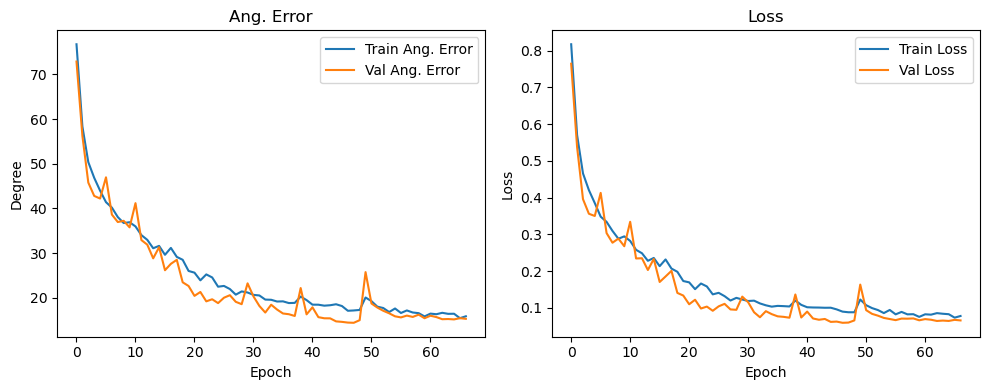

In [20]:
# 1. Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['gaze_angular_error'], label='Train Ang. Error')
    plt.plot(history.history['val_gaze_angular_error'], label='Val Ang. Error')
    plt.title('Ang. Error')
    plt.xlabel('Epoch')
    plt.ylabel('Degree')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

## Visualize Gaze Prediction on Validation Set

In [26]:
def draw_gaze_from_pupils(img, gaze_vec, l_pupil, r_pupil, color=(0, 255, 0), scale=50):
    img = img.copy()
    l_pt = (round(l_pupil[0]), round(l_pupil[1]))
    r_pt = (round(r_pupil[0]), round(r_pupil[1]))

    l_end = (round(l_pt[0] + gaze_vec[0] * scale), round(l_pt[1] + gaze_vec[1] * scale))
    r_end = (round(r_pt[0] + gaze_vec[0] * scale), round(r_pt[1] + gaze_vec[1] * scale))

    cv2.arrowedLine(img, l_pt, l_end, color, 2, tipLength=0.1)
    cv2.arrowedLine(img, r_pt, r_end, color, 2, tipLength=0.1)  # red from right eye
    return img

In [22]:
def draw_vector(img, vector, color=(0, 255, 0), scale=50):
    h, w = img.shape[:2]
    start = (w // 2, h // 2)
    end = (int(start[0] + vector[0]*scale), int(start[1] + vector[1]*scale))
    img_arrow = img.copy()
    cv2.arrowedLine(img_arrow, start, end, color, 2, tipLength=0.3)
    return img_arrow

In [23]:
best_model = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={"cosine_loss": cosine_loss})
last_model = tf.keras.models.load_model(LAST_MODEL_PATH, custom_objects={"cosine_loss": cosine_loss})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


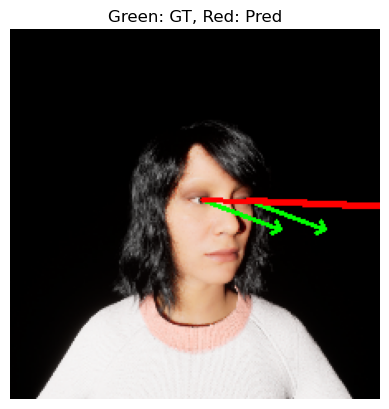

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


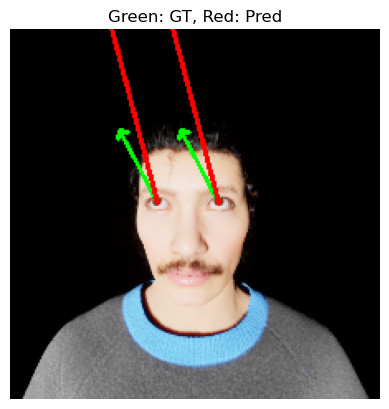

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


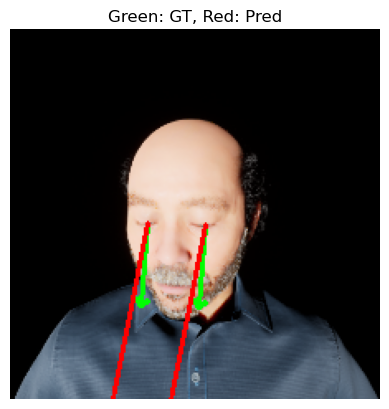

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


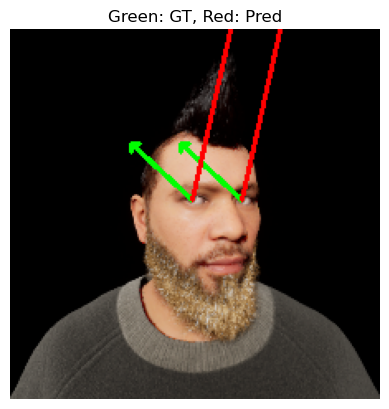

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


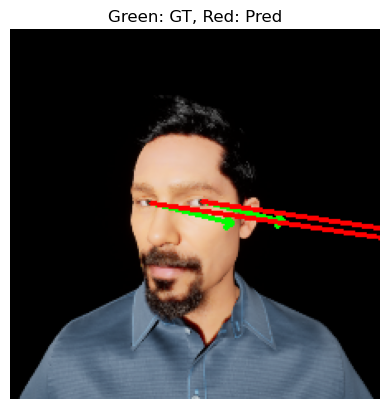

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


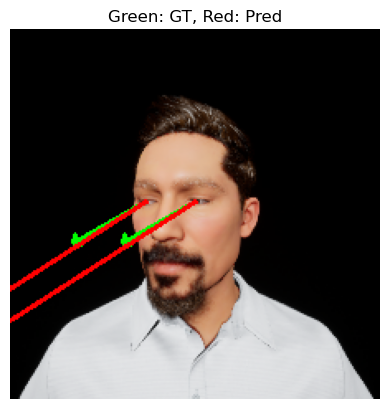

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


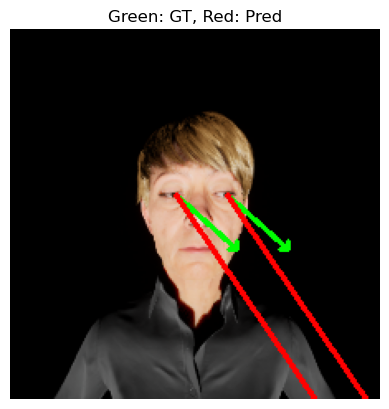

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


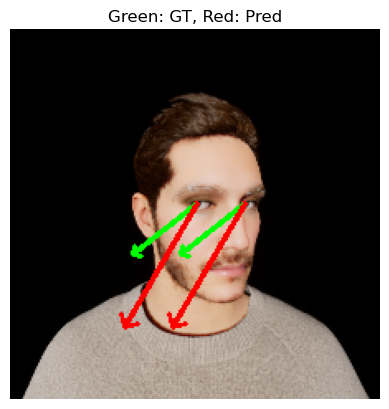

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


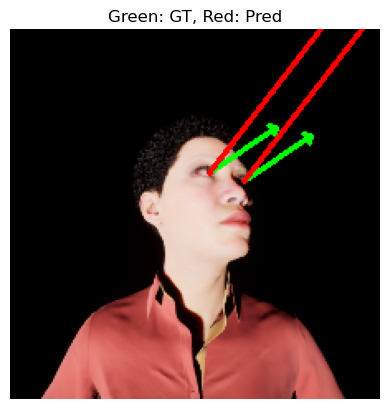

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


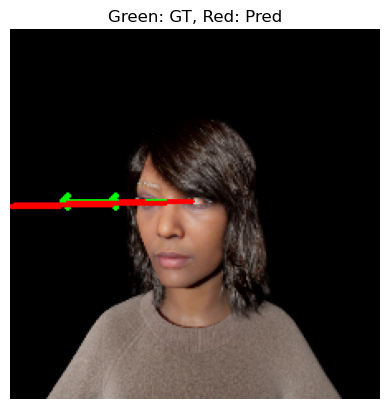

In [31]:
n = 10
for i in range(n):
    img = (X_img_val[i] * 255).astype(np.uint8)
    true_vec = y_val[i]
    pred_vec = model.predict([X_img_val[i:i+1], X_pupil_val[i:i+1]])[0]

    l_x, l_y, r_x, r_y = X_pupil_val[i]
    l_pupil = [l_x*224, l_y*224]
    r_pupil = [r_x*224, r_y*224]

    vis_img = draw_gaze_from_pupils(img, true_vec, l_pupil, r_pupil, color=(0, 255, 0))
    vis_img = draw_gaze_from_pupils(vis_img, pred_vec, l_pupil, r_pupil, color=(255, 0, 0))

    plt.imshow(vis_img)
    plt.title("Green: GT, Red: Pred")
    plt.axis("off")
    plt.show()

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model $TF_SAVE_MODEL_PATH $TFJS_MODEL_PATH

2025-05-26 12:28:19.086080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748262499.104098    8954 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748262499.109505    8954 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748262499.123802    8954 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748262499.123831    8954 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748262499.123836    8954 computation_placer.cc:177] computation placer alr